In [2]:
from utils.binaries import *
from utils.plotting import *
from itertools import product

14:06:16 (   +3.1s) [INFO   ] -- import logging
14:06:16 (  +161ms) [INFO   ] -- import numpy as np
14:06:16 (    +8ms) [INFO   ] -- import uncertainties
14:06:16 (  +555ms) [INFO   ] -- import pandas as pd
14:06:16 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
14:06:16 (    +2ms) [INFO   ] -- import binaries.tools as tools
14:06:17 (  +706ms) [INFO   ] -- import matplotlib.pyplot as plt
14:06:18 (  +748ms) [INFO   ] -- import seaborn as so
14:06:18 (    +5ms) [INFO   ] -- import plotting.tools as plot
14:06:18 (   +24ms) [DEBUG  ] -- font size set to 9.5
14:06:18 (    +2ms) [DEBUG  ] -- label size set to 13.0
14:06:18 (    +4ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
14:06:18 (    +1ms) [DEBUG  ] -- markersize set to 2.0
14:06:18 (    +2ms) [DEBUG  ] -- usetex set to False


In [8]:
def read(station):

    multiplicities = range(5, 45)
    threshold = np.linspace(0.05, 3.00, 295)
    all_params = list(product(multiplicities, threshold))

    base = '/cr/data01/filip/Data/SSDtotRateMap/'
    data = np.loadtxt(f'{base}/{station}_SSD.txt')
    container = np.empty((4, len(all_params)))
    container[:] = np.nan
    x, y, z1, z2 = container

    for row in data:
        x_, y_, z_tot, z_totd, t = row
        # print(x_, y_, z_tot, z_totd, t)

        for this_index, (_x, _y) in enumerate(all_params):
            if _x == x_ and _y == y_: break

        x[this_index] = x_
        y[this_index] = y_
        z1[this_index] = z_tot
        z2[this_index] = z_totd

    assert len(DAQ_seconds := np.unique(data[:, 4])) == 1, f"DAQ time(s) do not match: {DAQ_seconds = }"

    return x, y, z1, z2, *DAQ_seconds

def visualize(data, l=None):

    multiplicities = range(5, 45)
    threshold = np.linspace(0.05, 3.00, 295)

    x, y, z1, z2, time = data
    z1 = z1.reshape((len(multiplicities), len(threshold))) / time
    z2 = z2.reshape((len(multiplicities), len(threshold))) / time
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

    
    # formatter = lambda x : fr'$10^{int(np.log10(x))}$ Hz'
    formatter = lambda x : f'{int(x) if int(x) != 0 else x} Hz'

    for ax, z, trigger in zip(axes, [z1, z2], ['ToT', 'ToTd']):

        ax.set_box_aspect(1)
        image = ax.imshow(z, extent=(0.05, 3.00, 5, 45), 
                          aspect='auto', 
                          cmap='viridis', 
                          origin='lower',
                          interpolation='none',
                          norm='log',
                          vmin=0.1, vmax=200)
        if l is not None:
            levels = ax.contour(z.T, levels=l, 
                                extent=(5, 45, 0, .25), 
                                origin='lower', 
                                alpha=0.9, 
                                colors='k',
                                vmin=0, vmax=150,)
            ax.clabel(levels, colors='k', fontsize=9, inline=True, inline_spacing=100, fmt=formatter)

        ax.set_ylabel('threshold / nominal')
        ax.set_xlabel('occupancy / bins')

        # ax.annotate('current', (13, 0.2), (13, 0.21), horizontalalignment='right')
        # ax.scatter(13, 0.2, marker='v', s=15, c='r')

        ax.set_title(f'{trigger}, {time:.1f} s of DAQ')
        plt.colorbar(image, label='rate / Hz', shrink=0.74)
        ax.minorticks_off()

        ax.set_xlim(3)

    # yticks = np.arange(0, 0.241, 0.02)
    # _ = ax.set_yticks(yticks[::2], [f"{x/0.2:.1f}" for x in yticks[::2]])

/tmp/ipykernel_882135/1938566673.py:72: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(3)


<Figure size 3960x1980 with 0 Axes>

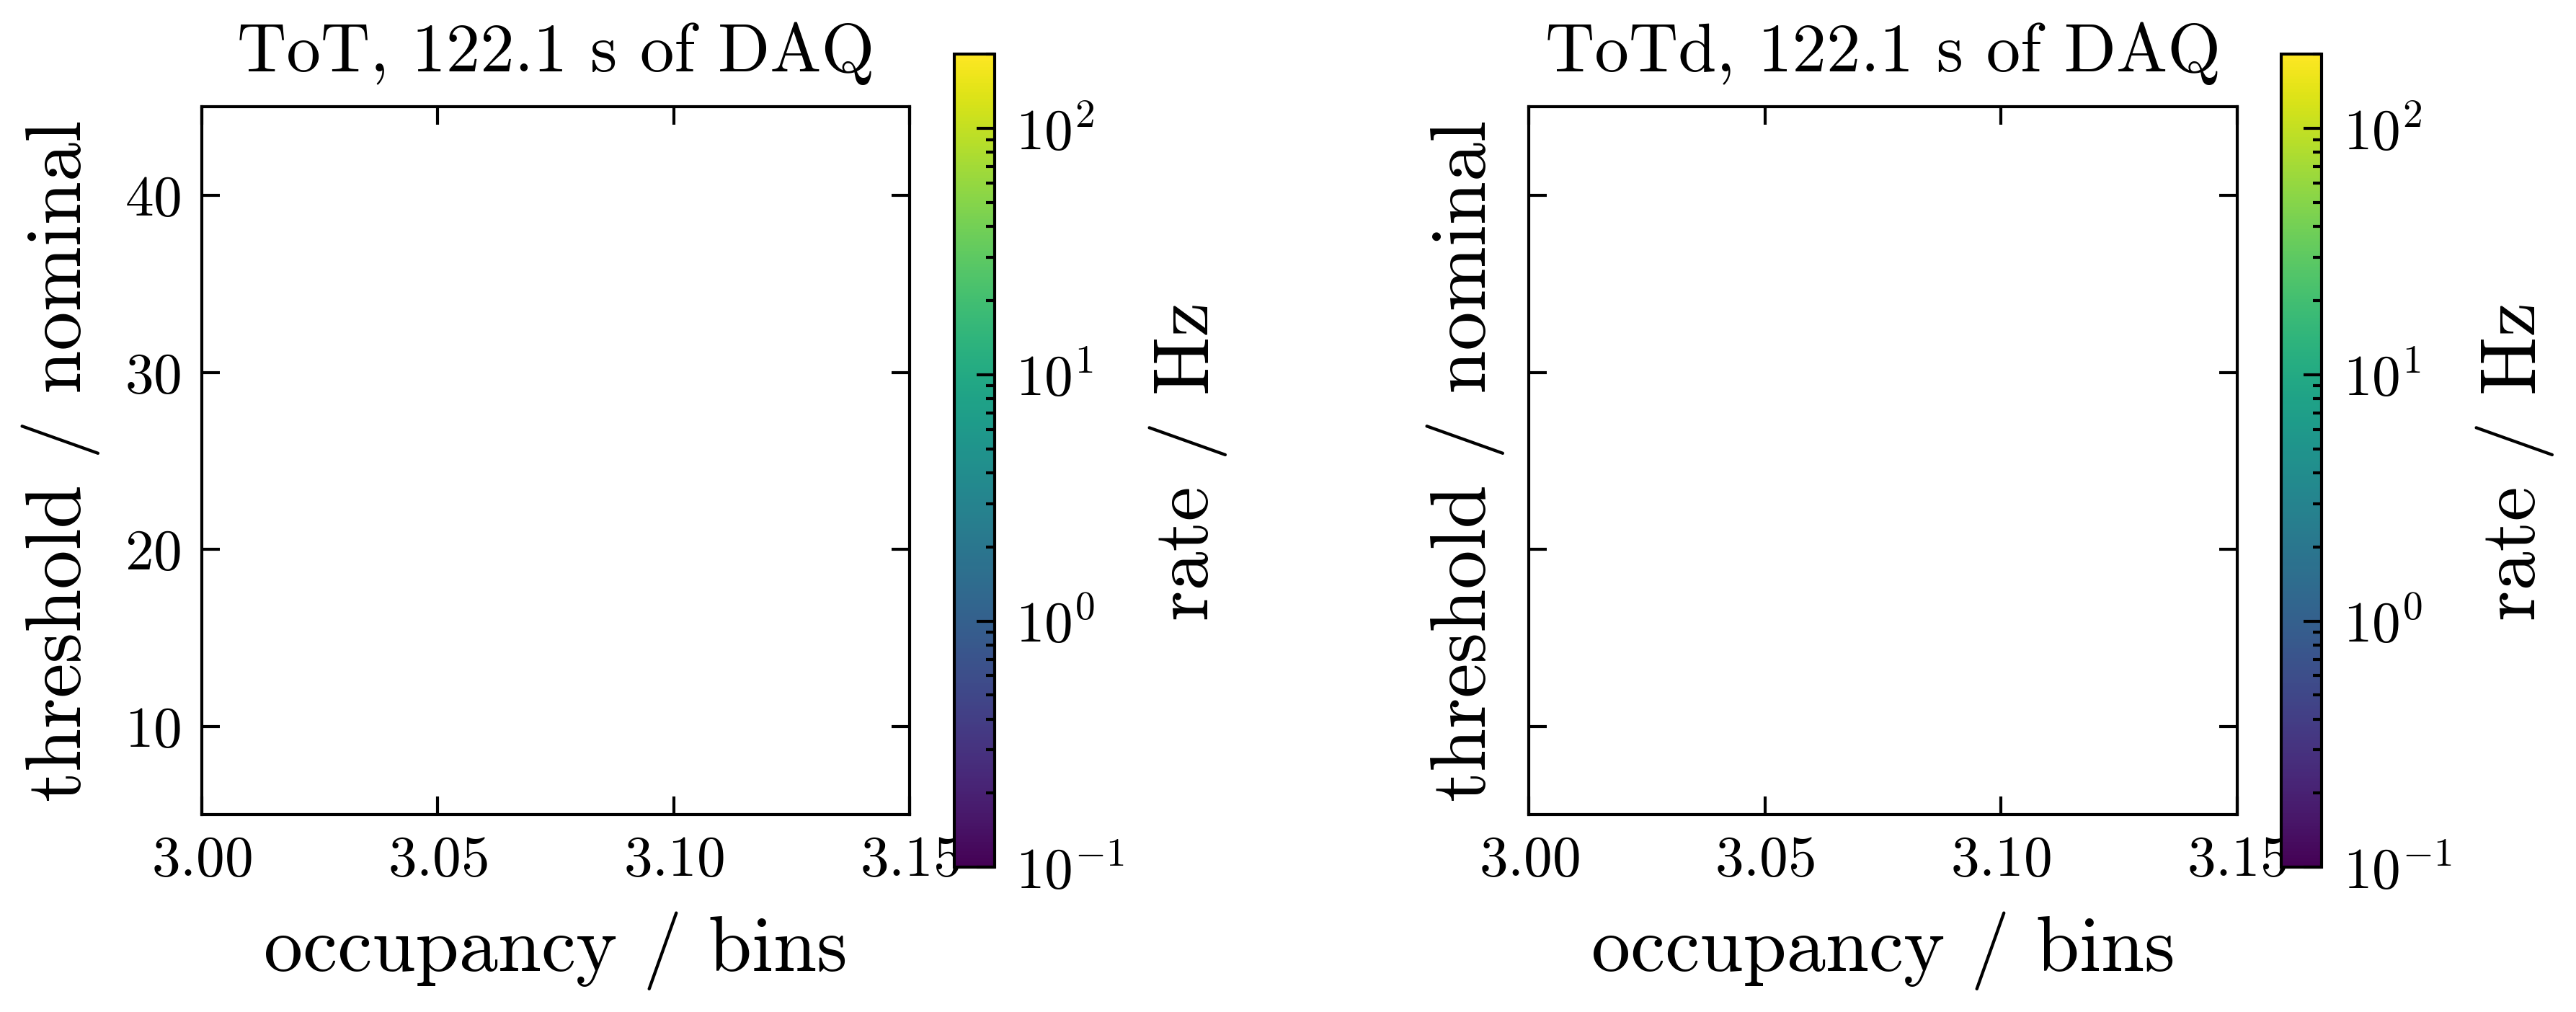

In [9]:
for station in ['Nadia']:
    fig = plt.figure()
    data_nadia = read(station)
    visualize(data_nadia)
    plt.subplots_adjust(wspace=0.5)
    # plt.savefig(f'/cr/data01/filip/plots/UubRandoms/ssd_tot_rate_maps/{station}.png')